# Zillow Regression Project
## *Predicting Assessed Property Values*

by Kristofer Rivera
2022-03-30

## Project Overview

### Project Description

The scenario for this project assumes that I am a new junior data scientist on the Zillow data science team. The team has already built a model to predict property tax assessed values of Single Family Properties that had a transaction in 2017. They would like me to provide my own insights and see if I can build a better regression model that improves upon their work.

### Project Goals
- Construct an ML Regression model that predicts property tax assessed values of Single Family Properties that had a transaction in 2017 using attributes of the properties.
- Find the key drivers of property value for single family properties.
- Make recommendations on what works or doesn't work in prediction of these homes' values.



### Necessary Imports

In [28]:
#Imports for dataframe manipulation 
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for user defined functions
import wrangle as wr
import explore as ex
import evaluate as ev

#Import for scaling data
from sklearn.preprocessing import MinMaxScaler

#Imports for modeling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Wrangle Zillow Data

To acquire the zillow data, I used the zillow database in our mySQL server. I selected columns I deemed potentially useful or necessary from the properties_2017 table and joined with the predictions_2017, and propertylandusetype tables. I used a where statement to filter my data to only include Single Family Residential properties that had a transaction in 2017.

`SELECT transactiondate, taxvaluedollarcnt, taxamount, roomcnt, bathroomcnt, bedroomcnt, garagecarcnt, numberofstories, lotsizesquarefeet, garagetotalsqft, calculatedfinishedsquarefeet, yearbuilt, fips, regionidcounty, regionidzip, propertycountylandusecode 
FROM properties_2017 
LEFT JOIN predictions_2017 USING (parcelid) 
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential') 
AND YEAR(transactiondate) = 2017;`. 
        
**Below is an example of the raw data acquired with my sql query (this is before any cleaning or prep):**

In [2]:
#Pre-defined function that gathers my data with a sql query and caches it locally as a csv, 
# Data is read from the csv on future calls of the function
df = wr.get_zillow()
df.head()

Using cached csv...


,transactiondate,taxvaluedollarcnt,taxamount,roomcnt,bathroomcnt,bedroomcnt,garagecarcnt,numberofstories,lotsizesquarefeet,garagetotalsqft,calculatedfinishedsquarefeet,yearbuilt,fips,regionidcounty,regionidzip,propertycountylandusecode
0,2017-01-09,180345.0,2527.17,0.0,3.0,4.0,NaN,NaN,12013.0,NaN,2963.0,1962.0,6037.0,3101.0,96267.0,0101
1,2017-01-09,261105.0,3097.51,0.0,2.0,3.0,NaN,NaN,5410.0,NaN,1490.0,1968.0,6037.0,3101.0,96206.0,0100
2,2017-01-09,1267762.0,15490.96,0.0,4.0,4.0,NaN,NaN,17630.0,NaN,4228.0,1988.0,6037.0,3101.0,96120.0,0101
3,2017-01-09,480444.0,5818.63,0.0,2.0,2.0,NaN,NaN,9053.0,NaN,1578.0,1961.0,6037.0,3101.0,96387.0,0101
4,2017-01-09,336000.0,5386.29,0.0,1.0,4.0,NaN,NaN,5956.0,NaN,1483.0,1927.0,6037.0,3101.0,96110.0,0101


In [3]:
# Summary of my raw data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transactiondate               52441 non-null  object 
 1   taxvaluedollarcnt             52440 non-null  float64
 2   taxamount                     52437 non-null  float64
 3   roomcnt                       52441 non-null  float64
 4   bathroomcnt                   52441 non-null  float64
 5   bedroomcnt                    52441 non-null  float64
 6   garagecarcnt                  18015 non-null  float64
 7   numberofstories               14561 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
 9   garagetotalsqft               18015 non-null  float64
 10  calculatedfinishedsquarefeet  52359 non-null  float64
 11  yearbuilt                     52325 non-null  float64
 12  fips                          52441 non-null  float64
 13  r

**My original raw data frame contained 52441 rows and 16 columns.**

**To clean/prep the data, I did the following:**

1. Renamed columns for clarity and readability.
2. Removed outliers that were skewing my data in order to achieve more normal distributions.
3. Changed data types where appropriate for readability or to denote categorical variables. (Floats to ints, ints to strings/objects.)
4. For clearer exploration, I converted the fips column into a county column, replacing the numerical values with the corresponding county names based on information gathered from https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
5. I imputed null values for year_built based on the median year.

**Results:**
- 44884 Rows
- 8 Columns 
  
### Before exploration of variable relationships, I split the data into train, validate, and test data sets.

**Below is an example of what the data looks like after data cleaning and splitting:**

In [4]:
train, validate, test = wr.wrangle_zillow_mvp()
train.head()

Using cached csv...


,bedrooms,bathrooms,year_built,square_feet,county,assessed_value
17219,4,2.0,1979.0,1909,Ventura,296809
36164,3,3.0,1999.0,3159,Ventura,938664
16548,4,3.0,1956.0,2825,Ventura,766513
29763,3,2.0,1947.0,1350,Los Angeles,464414
22852,2,1.0,1947.0,740,Orange,117601


- Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data. 
- The validate is used to verify that our models built are not overfit to the train dataset. 
- The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

## Exploratory Analysis ##
**I started exploratory analysis by examning the correlations of all by variables with assessed_value.**

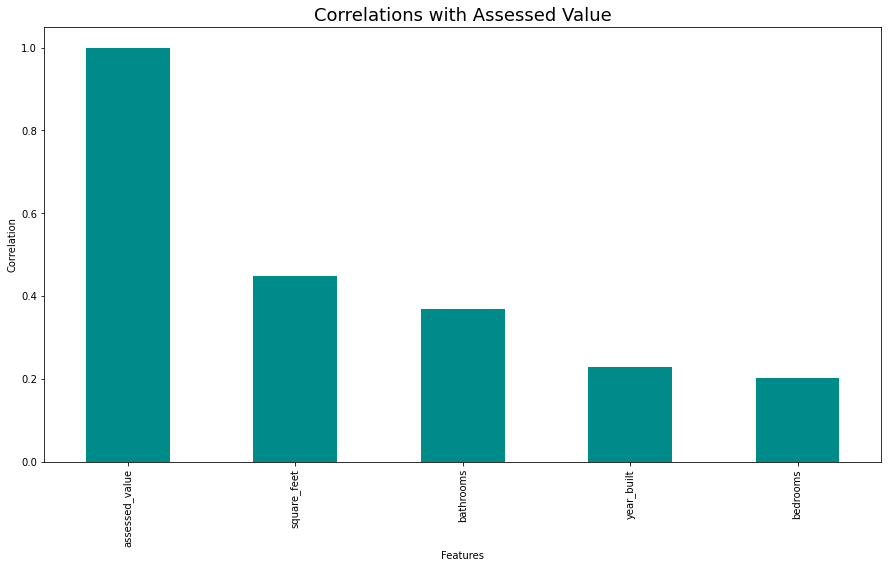

In [5]:
ex.plot_correlations(train)

**Takeaways:**
- This gave me a good starting point by showing which variables are most highly correlated with my target: 
    - square_feet and number of bathrooms are my top two variables in terms of correlation.

**To guide my exploration, I sought to answer these initial questions:**

1. Is there a linear relationship between a home's number of bedrooms and it's assessed value?
2. Is there a linear relationship between a home's number of bathrooms and it's assessed value?
3. Do homes have higher assessed value based on what county they are in? 
4. Does the year a home was built (how old it is) affect it's assessed value? 

### Question 1: Is there a linear relationship between a home's number of bedrooms and it's assessed value?

$H0$: The number of bedrooms is not linearly correlated with assessed home value.

$Ha$: The number of bedrooms is linearly correlated with assessed home value.

In [6]:
# Predefined function that conducts a pearsonr test and prints out the results
ex.pearsonr(train.bedrooms, train.assessed_value)

The correlation value between the two variables is 0.2009 and the P-Value is 7.288335563165177e-231.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


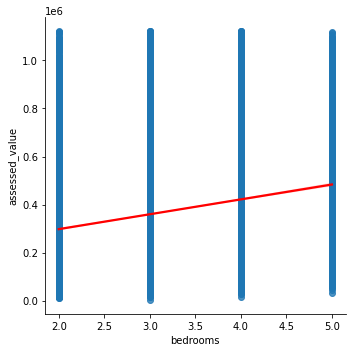

In [7]:
# Create a line plot with regression line to visualize relationship
sns.lmplot(x='bedrooms', y='assessed_value', data=train, line_kws={'color':'red'})
plt.show()

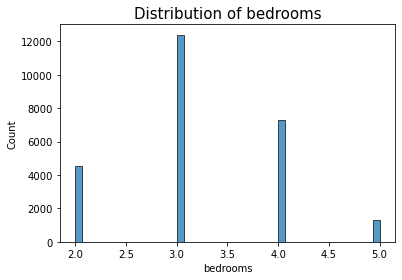

In [8]:
ex.plot_distribution(train, 'bedrooms')

**Takeaway:**
- As would be expected, the more bedrooms a home has the higher it's assessed value. There is a linear correlation.
- Most properties have between three and four bedrooms.

### Question 2:  Is there a linear relationship between a home's number of bathrooms and it's assessed value?

$H0$: The number of bathrooms a home has is not linearly correlated with assessed home value.

$Ha$: The number of bathrooms a home has is linearly correlated with assessed home value.

In [9]:
# Predefined function that conducts a pearsonr test and prints out the results
ex.pearsonr(train.bathrooms, train.assessed_value)

The correlation value between the two variables is 0.3697 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


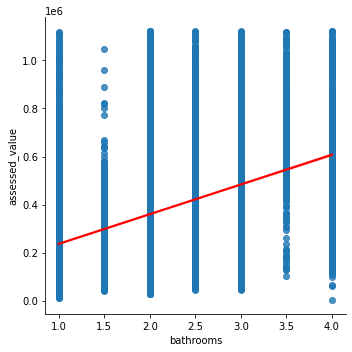

In [10]:
# Create a line plot with regression line to visualize relationship
sns.lmplot(x='bathrooms', y='assessed_value', data=train, line_kws={'color':'red'})
plt.show()

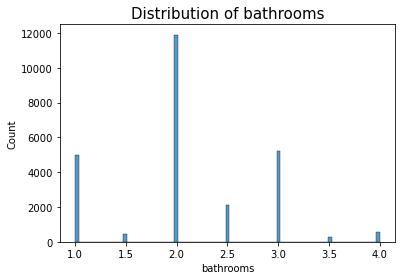

In [11]:
ex.plot_distribution(train, 'bathrooms')

**Takeaways:**
- As would be expected, the more bathrooms a home has the higher it's assessed value. There is a linear correlation.
- Interestingly, the correlation is confimed here to be higher for bathrooms than for bedrooms. 
    - Perhaps this is because homes with more than two bathrooms tend to also have many bedrooms. 

### Question 3: Do homes have higher assessed value based on what county they are in?

$H0$: County location is not correlated with assessed home value.

$Ha$: County location is correlated with assessed home value.

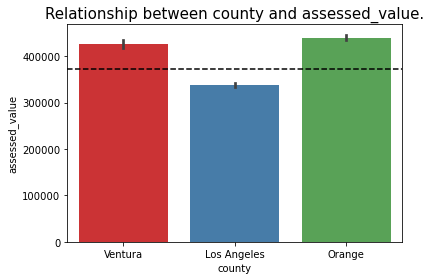

In [12]:
ex.plot_bar(train, 'county', 'assessed_value')

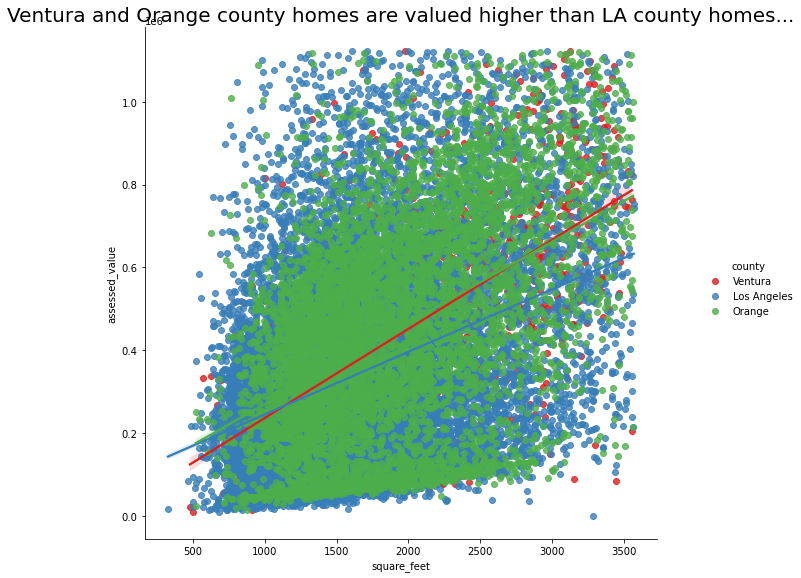

In [13]:
sns.lmplot(x = 'square_feet', y= 'assessed_value', hue='county', data=train, size = 8, palette = 'Set1')
plt.title('Ventura and Orange county homes are valued higher than LA county homes...', fontsize= 20)
plt.show()

### Follow up question: Do homes in Ventura and Orange County have more square feet than homes in LA County?

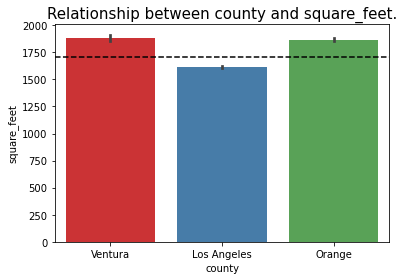

In [14]:
ex.plot_bar(train, 'county', 'square_feet')

**Takeaways:**
- Homes in Ventura and Orange county do seem to be valued higher on average than homes in LA county. 
- That said, homes in these counties also have more square footage, which is likely the primary reason for the higher values.

### Question 4: Does the year a home was built (how old it is) affect it's assessed value?

$H0$: The year a home was built is not linearly correlated with assessed home value.

$Ha$: The year a home was built is linearly correlated with assessed home value.

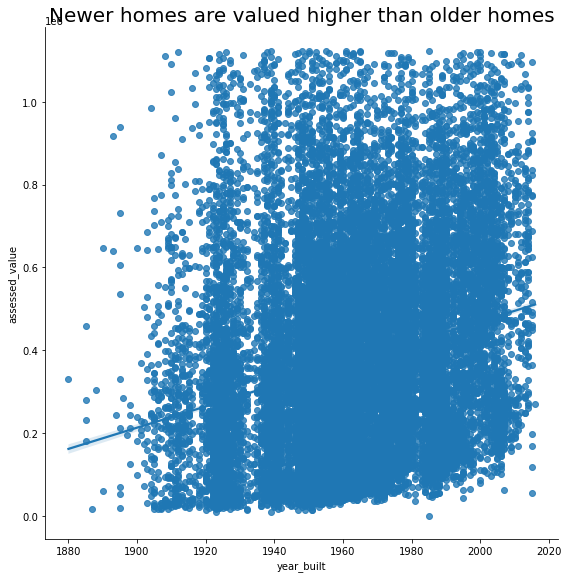

In [15]:
sns.lmplot(x = 'year_built', y= 'assessed_value', data=train, size = 8, palette = 'Set1')
plt.title('Newer homes are valued higher than older homes', fontsize= 20)
plt.show()

**Takeaway:**
- There is a linear relationship betweent the age of a home and it's assessed value. Newer homes are generally worth more.

## Model and Evaluate

### Preprocessing

**Scale Data**

**Below is a comparison of my variable distributions before and after scaling using a MinMaxScaler:**

(<Figure size 1152x648 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bedrooms before scaling'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms after scaling with MinMaxScaler'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bathrooms before scaling'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms after scaling with MinMaxScaler'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'square_feet before scaling'}, xlabel='square_feet', ylabel='count'>,
         <AxesSubplot:title={'center':'square_feet after scaling with MinMaxScaler'}, xlabel='square_feet', ylabel='count'>]],
       dtype=object))

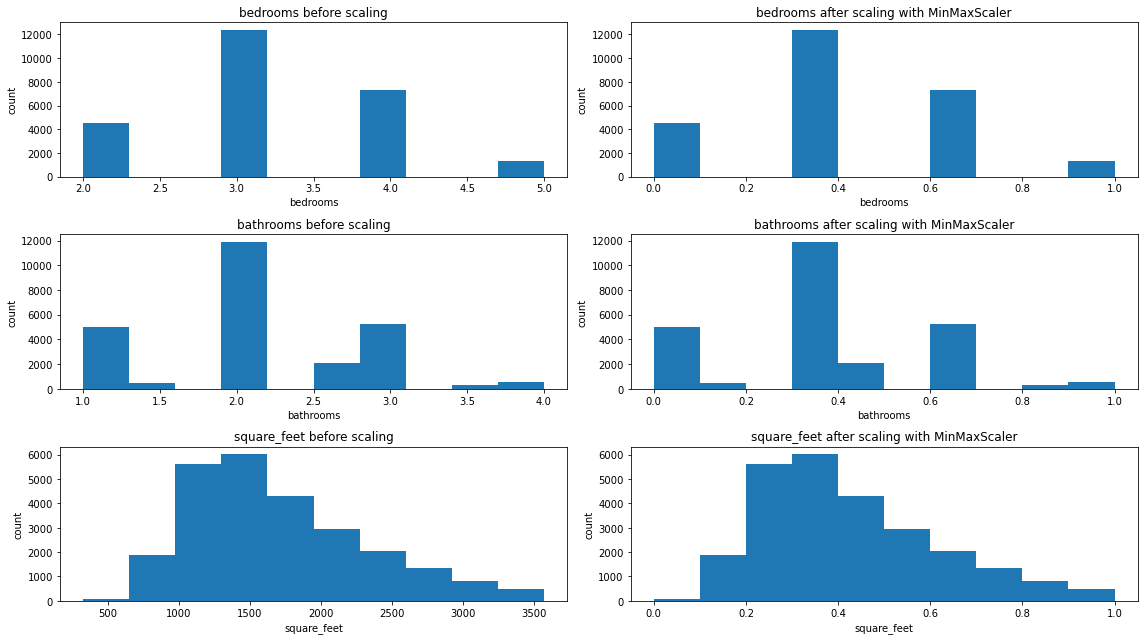

In [16]:
# Visualize scaling of data before actually scaling
wr.visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = ['bedrooms', 'bathrooms', 'square_feet'])

**Since distributions seem to be roughly similar and close to normal I will move forward with the MinMaxScaler.**

In [17]:
# Scale data using MinMax Scaler
train_scaled, validate_scaled, test_scaled = wr.scale_data_mvp(train, validate, test)

#### Project Stipulation:
"For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product)."

- I will create my X and Y groups accordingly to reach an MVP

In [18]:
#First Iteration - split into X and Y using scaled data
X_train, y_train = train_scaled.drop(columns=['assessed_value', 'year_built', 'county']), train_scaled.assessed_value
X_validate, y_validate = validate_scaled.drop(columns=['assessed_value', 'year_built', 'county']), validate_scaled.assessed_value
X_test, y_test = test_scaled.drop(columns=['assessed_value', 'year_built', 'county']), test_scaled.assessed_value

#### Calculate our baseline
- Will caculate baseline based on both the mean and median and evaluate which has the lowest RMSE to decide which will be the baseline our model needs to beat.

In [20]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)

# Create new data frame to hold my in sample predictions and the same for out of sample
predictions = y_train.copy()
predictions = predictions.rename(columns={'assessed_value':'actual'})

#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = y_train.assessed_value.mean()
predictions['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = y_train.assessed_value.median()
predictions['baseline_median'] = baseline_median

In [21]:
# Calculate RMSE based on mean 
mean_rmse = ev.rmse(predictions.actual, predictions.baseline_mean)

# Calculate RMSE based on median 
median_rmse = ev.rmse(predictions.actual, predictions.baseline_median)

print("RMSE using Mean as Baseline: ", mean_rmse, 
      "\nRMSE using Median as Baseline: ", median_rmse)

RMSE using Mean as Baseline:  243610.20860463442 
RMSE using Median as Baseline:  246147.84924914845


**The lower RMSE indicates a more predictive model so we will use the mean as our baseline.**

## Regression Models - MVP

**For my MVP I trained and fit the 4 models listed here:**

Model 1 - Simple Model (Ordinary Least Squares)

Model 2 - LASSO + LARS

Model 3 - Polynomial Regression

Model 4 - Generalized Linear Model


**These were the evaluation results:**

RMSE using OLS
Train/In-Sample:  216208.36 
Validate/Out-of-Sample:  217786.84
----------------------------------------------------
RMSE using LassoLars
Train/In-Sample:  216208.7 
Validate/Out-of-Sample:  217788.65
----------------------------------------------------
RMSE using Polynomial Features
Train/In-Sample:  216040.7 
Validate/Out-of-Sample:  217801.43
----------------------------------------------------
RMSE using Generalized Linear Model
Train/In-Sample:  216461.09 
Validate/Out-of-Sample:  218190.72


**All models performed better than the baseline, but the Simple OLS Model had the lowest RMSE score for both in-sample and out-of-sample data, so I chose it as my best model.**

### Evaluate Model 1 on Test Data

In [29]:
#Create model
lm = LinearRegression(normalize = True)

#Fit model to train
lm.fit(X_train, y_train)

#Make predictions on test dataset
predictions['ols_model'] = lm.predict(X_train)

# Calculate RMSE
test_rmse = ev.rmse(predictions.actual, predictions.ols_model)

#Calculate R2 Score
test_r2 = r2_score(predictions.actual, predictions.ols_model)


print("RMSE using OLS\nTest/Out-of-Sample: ", test_rmse) 

print("R2 Score using OLS\nTest/Out-of-Sample: ", test_r2) 
    

RMSE using OLS
Test/Out-of-Sample:  216208.35984505145
R2 Score using OLS
Test/Out-of-Sample:  0.21231242102404468


### Visualize Model Performance

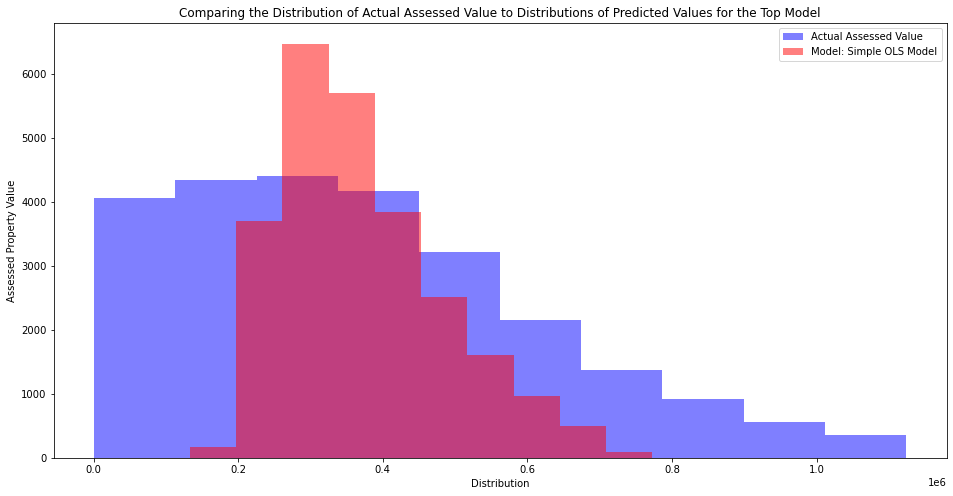

In [37]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(predictions.actual, color='blue', alpha=.5, label="Actual Assessed Value")
plt.hist(predictions.ols_model, color='red', alpha=.5, label="Model: Simple OLS Model")
plt.xlabel("Distribution")
plt.ylabel("Assessed Property Value")
plt.title("Comparing the Distribution of Actual Assessed Value to Distributions of Predicted Values for the Top Model")
plt.legend()
plt.show()

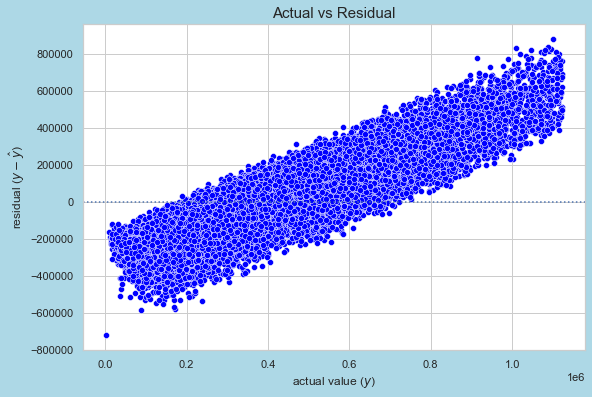

In [38]:
ev.plot_residuals(predictions.actual, predictions.ols_model, predictions)

## Conclusions
### I was able to complete my 3 original goals:

**Built a Machine Learning Regression model that predicts property tax assessed values of Single Family Properties that had a transaction in 2017 using attributes of the properties:**
- The simple Ordinary Least Squares Model was my best performing model and beat the baseline model.
- RMSE of 216208.36
- R2 Score of 0.21

**Discovered key drivers of assessed property value:**
- Having more square footage increases the predited value of a property.
- Having more bedrooms and bathrooms increases the predicted value of a property. 
- Location is a driver for assessed property value.
    - Ventura and Orange County properties are valued higher than LA county.
    - They are also larger properties on average which is likely the main driver.
- Home age is a driver of assessed property value. The newer the home the higher the value.

## Recommendations
- I recommend the use of my simple OLS model to make predictions. 
- Based on findings, when building future predictive models I would focus on the square footage, number of bathrooms, and age of properties which were my top 3 drivers.

### Next Steps -- If I had more time I would....
- Conduct feature engineering such as creating a new continuous feature that calculates the age of a property in years using the year_built variable. 
- Investigate my initial questions further -- Example: Determine whether or not county location still increases home value when all other variables are roughly the same.
- Try new models using different paramaters and feature combinations